<a href="https://colab.research.google.com/github/sohamtalukdar/Segmentation-of-Kidneys-in-MRI/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nibabel --upgrade
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import nibabel as nib
from nibabel.processing import conform
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from keras import backend as K
from PIL import ImageOps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 8.7 MB/s 
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
"""Shamelessly taken from Alex Daniel - will cite properly!"""

def rescale(data, black=None, white=None):
    if black is None:
        black = np.mean(data) - 0.5 * np.std(data)
        if black < data.min():
            black = data.min()
    if white is None:
        white = np.mean(data) + 4 * np.std(data)
        if white > data.max():
            white = data.max()
    data = np.clip(data, black, white) - black
    data = data / (white - black)
    return data

def normalise_image(image, affine):

    image = rescale(image)
    img = nib.Nifti1Image(image, affine)
    zoom = img.header.get_zooms()
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, zoom[-1] * 0.998),
                  orientation='LIP')
    image = img.get_fdata()
    image = resize(image, (256, 256, image.shape[2]))
    zoom = img.header.get_zooms()
    return image
  
def normalise_mask(mask, affine):

    img = nib.Nifti1Image(mask, affine)
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, img.header.get_zooms()[-1] *
                              0.998),
                  orientation='LIP')
    mask = img.get_fdata()
    mask = resize(mask, (256, 256, mask.shape[2]))
    mask = np.round(mask)
    return mask

In [ ]:
ground_truths = []
base_scans = []
dir = '/content/drive/MyDrive/ColabNotebooks/UNet/'
for f in sorted(os.listdir(dir + 'GroundTruth/')):
  image = nib.load(dir + 'GroundTruth/' + f)
  ground_truths.append(image)
for f in sorted(os.listdir(dir + 'Masks/')):
  image = nib.load(dir + 'Masks/'+ f)
  base_scans.append(image)
print(ground_truths[1].header.get_data_shape())


(256, 256, 17)


In [ ]:
gt_arrays = []
gt_affine = []
base_arrays = []
base_affine = []
for img in ground_truths:
  affine = img.affine
  gt_voxels = img.get_fdata()
  normalised = normalise_mask(gt_voxels, affine)
  gt_arrays.append(normalised)
for img in base_scans:
  affine = img.affine
  base_voxels = img.get_fdata()
  normalised = normalise_image(base_voxels, affine)
  base_arrays.append(base_voxels)
pairs = zip(gt_arrays, base_arrays)

print(gt_arrays[1].shape)
print(len(gt_arrays), len(gt_affine))
print(type(base_arrays[2]))




(256, 256, 17)
10 0
<class 'numpy.ndarray'>


In [ ]:
x_series = pd.Series(base_arrays)
y_series = pd.Series(gt_arrays)

#also courtesy of Alex Daniel

def tf_arrays(series):
    data = np.concatenate(series, 2)
    data = np.swapaxes(data, 0, 2)
    data = np.swapaxes(data, 1, 2)
    data = np.expand_dims(data, 3)
    return data

x_data = tf_arrays(x_series)
y_data = tf_arrays(y_series)
"""
for img in base_arrays:
  for i in range(0,17):
    x_images.append(img[:,:,i,np.newaxis])
for img in gt_arrays:
  for i in range(0,17):
    y_images.append(img[:,:,i,np.newaxis])
"""

print(len(x_data), len(y_data))
print(x_data[1].shape, y_data[1].shape)


"""
fig, ax = plt.subplots(2)
ax[0].imshow(x_images[46])
ax[1].imshow(y_images[46])
plt.show()
"""

170 170
(256, 256, 1) (256, 256, 1)


'\nfig, ax = plt.subplots(2)\nax[0].imshow(x_images[46])\nax[1].imshow(y_images[46])\nplt.show()\n'

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                     test_size = 0.3)

In [ ]:
def dice_coef(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    return 2*intersection / union

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
### UNET

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2



def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1


def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, (1,1), padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model



In [ ]:
input_size = (256, 256,1)
model = U_Net(input_size)

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.0001), 
              loss="sparse_categorical_crossentropy")
steps = 5
# Train the model, doing validation at the end of each epoch.
results = model.fit(x_train, y_train, steps_per_epoch = steps, epochs = 100,validation_data = (x_valid, y_valid))

Epoch 1/100
5/5 [==============================] - 28s 3s/step - loss: 1.3886 - val_loss: 2.5450
Epoch 2/100
5/5 [==============================] - 4s 723ms/step - loss: 1.0871 - val_loss: 2.3747
Epoch 3/100
5/5 [==============================] - 4s 723ms/step - loss: 0.8660 - val_loss: 2.3179
Epoch 4/100
5/5 [==============================] - 4s 728ms/step - loss: 0.6937 - val_loss: 2.3517
Epoch 5/100
5/5 [==============================] - 4s 727ms/step - loss: 0.5629 - val_loss: 1.4834
Epoch 6/100
5/5 [==============================] - 4s 725ms/step - loss: 0.4611 - val_loss: 1.0079
Epoch 7/100
5/5 [==============================] - 4s 729ms/step - loss: 0.3972 - val_loss: 42.3092
Epoch 8/100
5/5 [==============================] - 4s 729ms/step - loss: 0.3631 - val_loss: 46.1493
Epoch 9/100
5/5 [==============================] - 4s 724ms/step - loss: 0.3234 - val_loss: 12.6345
Epoch 10/100
5/5 [==============================] - 4s 724ms/step - loss: 0.2909 - val_loss: 23.4249
Epoch 1

2/2 [==============================] - 0s 178ms/step - loss: 0.0861


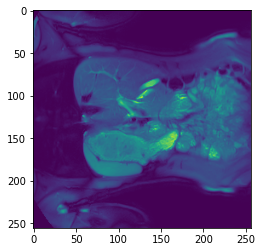

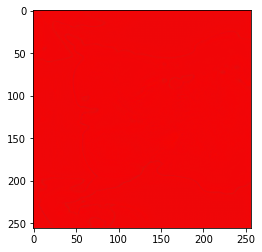

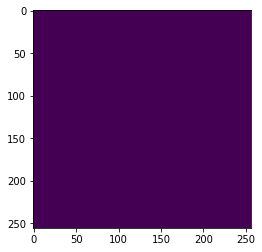

In [ ]:
model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_train)
plt.show()
i = 9
plt.imshow(np.squeeze(x_train[i]))
plt.show()
# plt.imshow(np.squeeze(y_train[i]))
# plt.show()
plt.imshow(np.squeeze(predicted_masks[i]))
plt.show()


def display_mask(j):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(predicted_masks[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    #display(img)
    plt.imshow(np.squeeze(mask))
    plt.show()

display_mask(predicted_masks[i])
